# Udacity Artificial Intelligence Nanodegree
## Computer Vision Capstone
## Project: Facial Keypoint Detection



In [1]:
# Import required libraries for this section

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math

---
<a id='step5'></a>

## Create a CNN to Recognize Facial Keypoints

OpenCV is often used in practice with other machine learning and deep learning libraries to produce interesting results.  In this stage of the project you will create your own end-to-end pipeline - employing convolutional networks in keras along with OpenCV - to apply a "selfie" filter to streaming video and images.  

You will start by creating and then training a convolutional network that can detect facial keypoints in a small dataset of cropped images of human faces.  We then guide you towards OpenCV to expanding your detection algorithm to more general images.  What are facial keypoints?  Let's take a look at some examples.

<img src="images/keypoints_test_results.png" width=400 height=300/>

Facial keypoints (also called facial landmarks) are the small blue-green dots shown on each of the faces in the image above - there are 15 keypoints marked in each image.  They mark important areas of the face - the eyes, corners of the mouth, the nose, etc.  Facial keypoints can be used in a variety of machine learning applications from face and emotion recognition to commercial applications like the image filters popularized by Snapchat.

### Make a facial keypoint detector

But first things first: how can we make a facial keypoint detector?  Well, at a high level, notice that facial keypoint detection is a *regression problem*.  A single face corresponds to a set of 15 facial keypoints (a set of 15 corresponding $(x, y)$ coordinates, i.e., an output point).  Because our input data are images, we can employ a *convolutional neural network* to recognize patterns in our images and learn how to identify these keypoint given sets of labeled data.

In order to train a regressor, we need a training set - a set of facial image / facial keypoint pairs to train on.  For this we will be using [this dataset from Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data). We've already downloaded this data and placed it in the `data` directory. Make sure that you have both the *training* and *test* data files.  The training dataset contains several thousand $96 \times 96$ grayscale images of cropped human faces, along with each face's 15 corresponding facial keypoints (also called landmarks) that have been placed by hand, and recorded in $(x, y)$ coordinates.  This wonderful resource also has a substantial testing set, which we will use in tinkering with our convolutional network.

To load in this data, run the Python cell below - notice we will load in both the training and testing sets.

The `load_data` function is in the included `utils.py` file.

In [2]:
from utils import *

# Load training set
X_train, y_train = load_data()
print("X_train.shape == {}".format(X_train.shape))
print("y_train.shape == {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(
    y_train.shape, y_train.min(), y_train.max()))

# Load testing set
X_test, _ = load_data(test=True)
print("X_test.shape == {}".format(X_test.shape))

Using TensorFlow backend.


X_train.shape == (2140, 96, 96, 1)
y_train.shape == (2140, 30); y_train.min == -0.920; y_train.max == 0.996
X_test.shape == (1783, 96, 96, 1)


The `load_data` function in `utils.py` originates from this excellent [blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/), which you are *strongly* encouraged to read.  Please take the time now to review this function.  Note how the output values - that is, the coordinates of each set of facial landmarks - have been normalized to take on values in the range $[-1, 1]$, while the pixel values of each input point (a facial image) have been normalized to the range $[0,1]$.  

Note: the original Kaggle dataset contains some images with several missing keypoints.  For simplicity, the `load_data` function removes those images with missing labels from the dataset.  As an __*optional*__ extension, you are welcome to amend the `load_data` function to include the incomplete data points. 

### Visualize the Training Data

Execute the code cell below to visualize a subset of the training data.

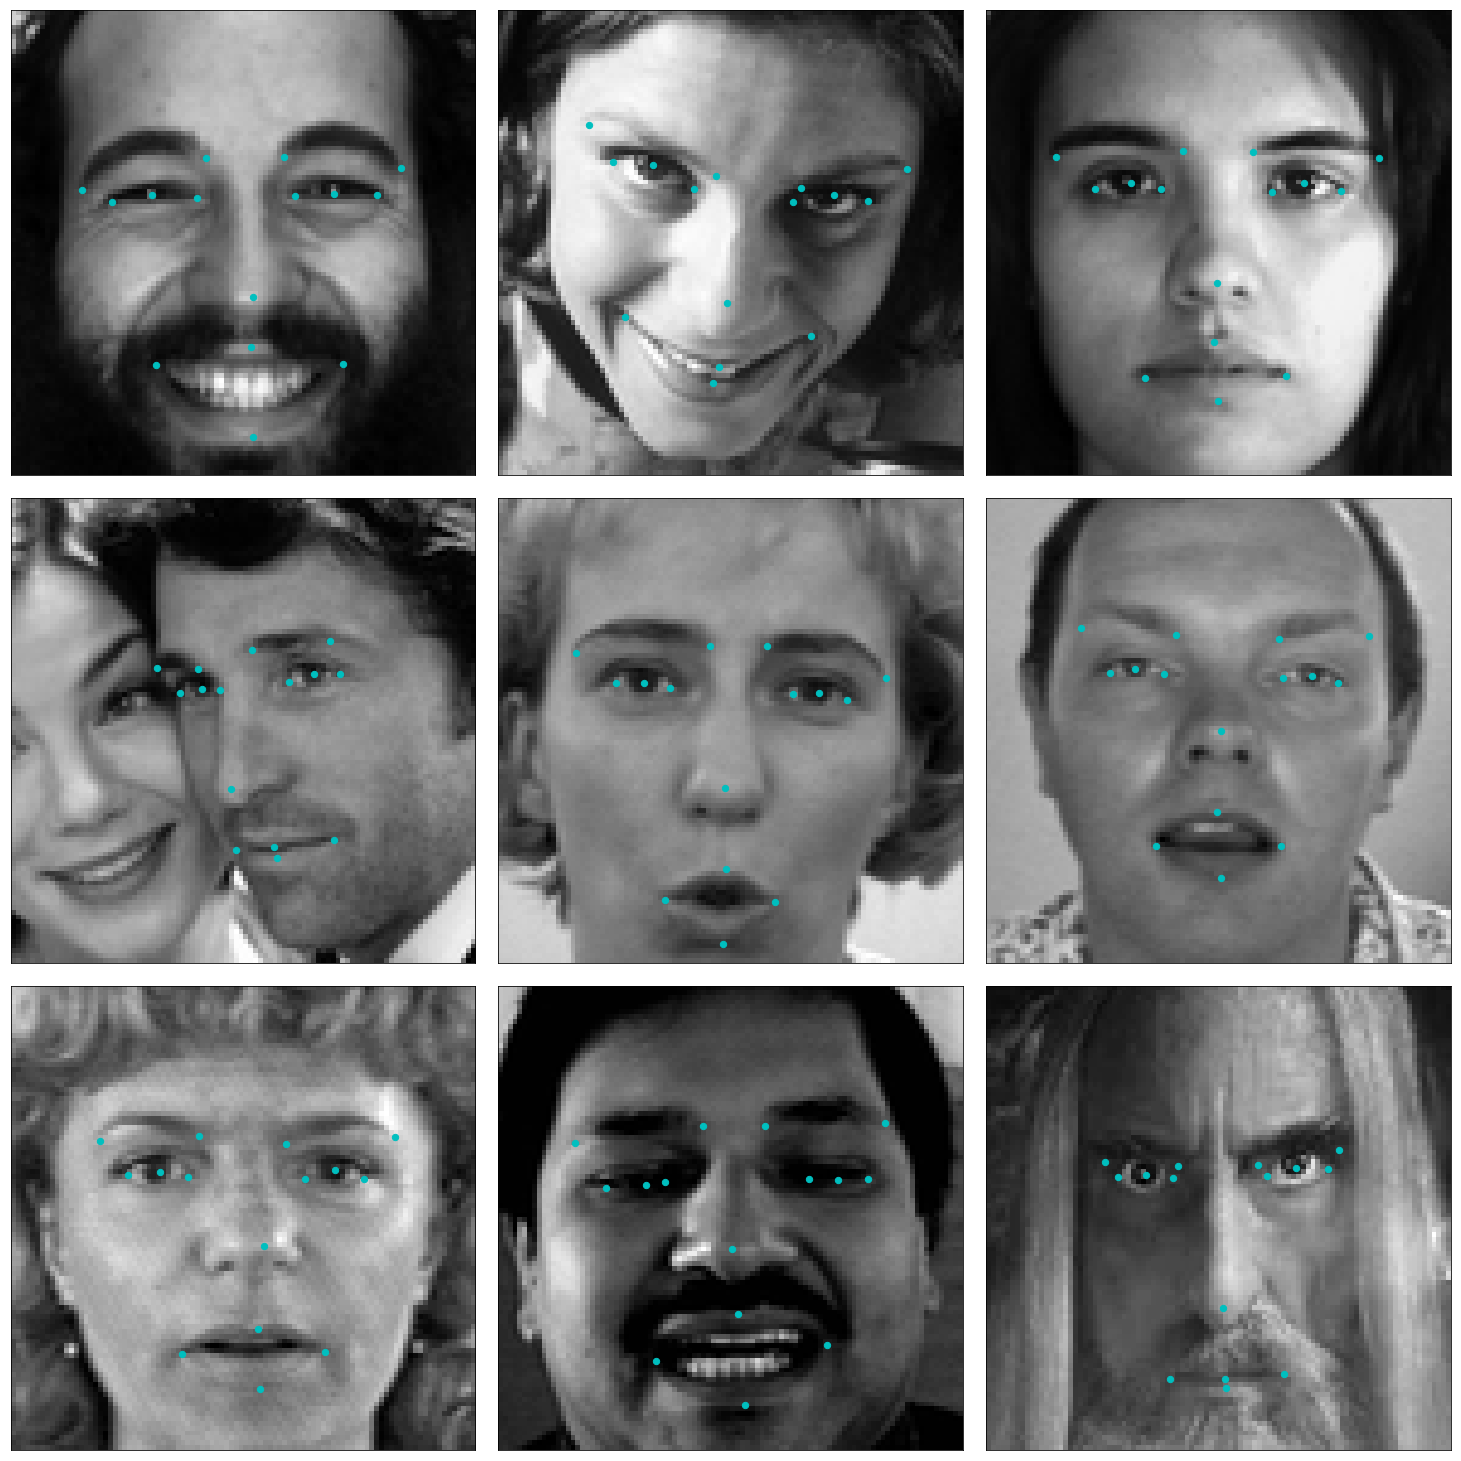

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], y_train[i], ax)

For each training image, there are two landmarks per eyebrow (**four** total), three per eye (**six** total), **four** for the mouth, and **one** for the tip of the nose.  

Review the `plot_data` function in `utils.py` to understand how the 30-dimensional training labels in `y_train` are mapped to facial locations, as this function will prove useful for your pipeline.

### (IMPLEMENTATION) Specify the CNN Architecture

In this section, you will specify a neural network for predicting the locations of facial keypoints.  Use the code cell below to specify the architecture of your neural network.  We have imported some layers that you may find useful for this task, but if you need to use more Keras layers, feel free to import them in the cell.

Your network should accept a $96 \times 96$ grayscale image as input, and it should output a vector with 30 entries, corresponding to the predicted (horizontal and vertical) locations of 15 facial keypoints.  If you are not sure where to start, you can find some useful starting architectures in [this blog](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/), but you are not permitted to copy any of the architectures that you find online.

In [10]:
# Import deep learning resources from Keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.layers import Flatten, Dense, BatchNormalization

input_shape = (X_train.shape[1], X_train.shape[2], 1)

def cnn_model(kernel_size=2, num_filters=1, num_dense_layers=1, num_nodes = 128, dropout_prob=0.0, optimizer='rmsprop'):
    
    model = Sequential()
    model.add(Conv2D(filters=num_filters, kernel_size=kernel_size, strides=1, activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=num_filters, kernel_size=kernel_size, strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))    
    model.add(Conv2D(filters=num_filters, kernel_size=kernel_size, strides=1, activation='relu'))
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(num_nodes, activation='relu'))
    model.add(Dropout(dropout_prob))
    model.add(BatchNormalization())
        
    for i in range(1,num_dense_layers):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(dropout_prob))
        model.add(BatchNormalization())
    
    model.add(Dense(30))
    
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

In [40]:
# Use Grid search with 3-fold cross validation to find the best values of parameters
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

model = KerasRegressor(build_fn=cnn_model, epochs=5, batch_size=32, verbose=0)

kernel_size = [2,3]
num_filters = [32,64]
num_dense_layers = [2,3]
num_nodes = [128,256]
dropout_prob = [0.2,0.3]
optimizer = ['rmsprop','sgd','adam']

param_grid = dict(kernel_size=kernel_size, num_filters=num_filters, num_dense_layers=num_dense_layers, num_nodes=num_nodes, \
                  dropout_prob=dropout_prob, optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

print("Lowest validation loss: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Lowest validation loss: 0.272424 using {'num_dense_layers': 3, 'kernel_size': 2, 'dropout_prob': 0.3, 'num_nodes': 128, 'optimizer': 'sgd', 'num_filters': 64}


In [11]:
## TODO: Specify a CNN architecture
# Your model should accept 96x96 pixel graysale images in
# It should have a fully-connected output layer with 30 values (2 for each facial keypoint)

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=2, strides=1, activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2))    
model.add(Conv2D(filters=64, kernel_size=2, strides=1, activation='relu'))

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(30))

# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 95, 95, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        16448     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
__________

---
<a id='step6'></a>

## Compile and Train the Model

After specifying your architecture, you'll need to compile and train the model to detect facial keypoints'

### (IMPLEMENTATION) Compile and Train the Model

Use the `compile` [method](https://keras.io/models/sequential/#sequential-model-methods) to configure the learning process.  Experiment with your choice of [optimizer](https://keras.io/optimizers/); you may have some ideas about which will work best (`SGD` vs. `RMSprop`, etc), but take the time to empirically verify your theories.

Use the `fit` [method](https://keras.io/models/sequential/#sequential-model-methods) to train the model.  Break off a validation set by setting `validation_split=0.2`.  Save the returned `History` object in the `history` variable.  

Your model is required to attain a validation loss (measured as mean squared error) of at least **XYZ**.  When you have finished training, [save your model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) as an HDF5 file with file path `my_model.h5`.

In [42]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

## TODO: Compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')

## TODO: Save the model as model.h5
checkpointer = ModelCheckpoint(filepath='my_model.h5',verbose=1, save_best_only=True)

## TODO: Train the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=30,
          validation_split=0.2, callbacks=[checkpointer],
          verbose=2, shuffle=True)

Train on 1712 samples, validate on 428 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 0.07264, saving model to my_model.h5
53s - loss: 1.1007 - val_loss: 0.0726
Epoch 2/30
Epoch 00001: val_loss improved from 0.07264 to 0.02964, saving model to my_model.h5
2s - loss: 0.5474 - val_loss: 0.0296
Epoch 3/30
Epoch 00002: val_loss improved from 0.02964 to 0.01062, saving model to my_model.h5
2s - loss: 0.2904 - val_loss: 0.0106
Epoch 4/30
Epoch 00003: val_loss improved from 0.01062 to 0.00664, saving model to my_model.h5
2s - loss: 0.1541 - val_loss: 0.0066
Epoch 5/30
Epoch 00004: val_loss improved from 0.00664 to 0.00523, saving model to my_model.h5
2s - loss: 0.0825 - val_loss: 0.0052
Epoch 6/30
Epoch 00005: val_loss improved from 0.00523 to 0.00484, saving model to my_model.h5
2s - loss: 0.0466 - val_loss: 0.0048
Epoch 7/30
Epoch 00006: val_loss improved from 0.00484 to 0.00460, saving model to my_model.h5
2s - loss: 0.0278 - val_loss: 0.0046
Epoch 8/30
Epoch 00007: val_loss

---
<a id='step7'></a>

## Visualize the Loss and Test Predictions

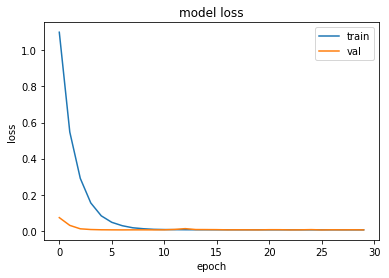

In [44]:
## TODO: Visualize the training and validation loss of your neural network
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

__Question 3:__  Do you notice any evidence of overfitting or underfitting in the above plot?  If so, what steps have you taken to improve your model?  Note that slight overfitting or underfitting will not hurt your chances of a successful submission, as long as you have attempted some solutions towards improving your model (such as _regularization, dropout, increased/decreased number of layers, etc_).

__Answer:__No significant evidence of overfitting as validation loss is stable and does not increase. However, earlystopping can be implemented in this case. Used dropout to prevent overfitting. Further used 3-fold cross validation in grid search

### Visualize a Subset of the Test Predictions

Execute the code cell below to visualize your model's predicted keypoints on a subset of the testing images.

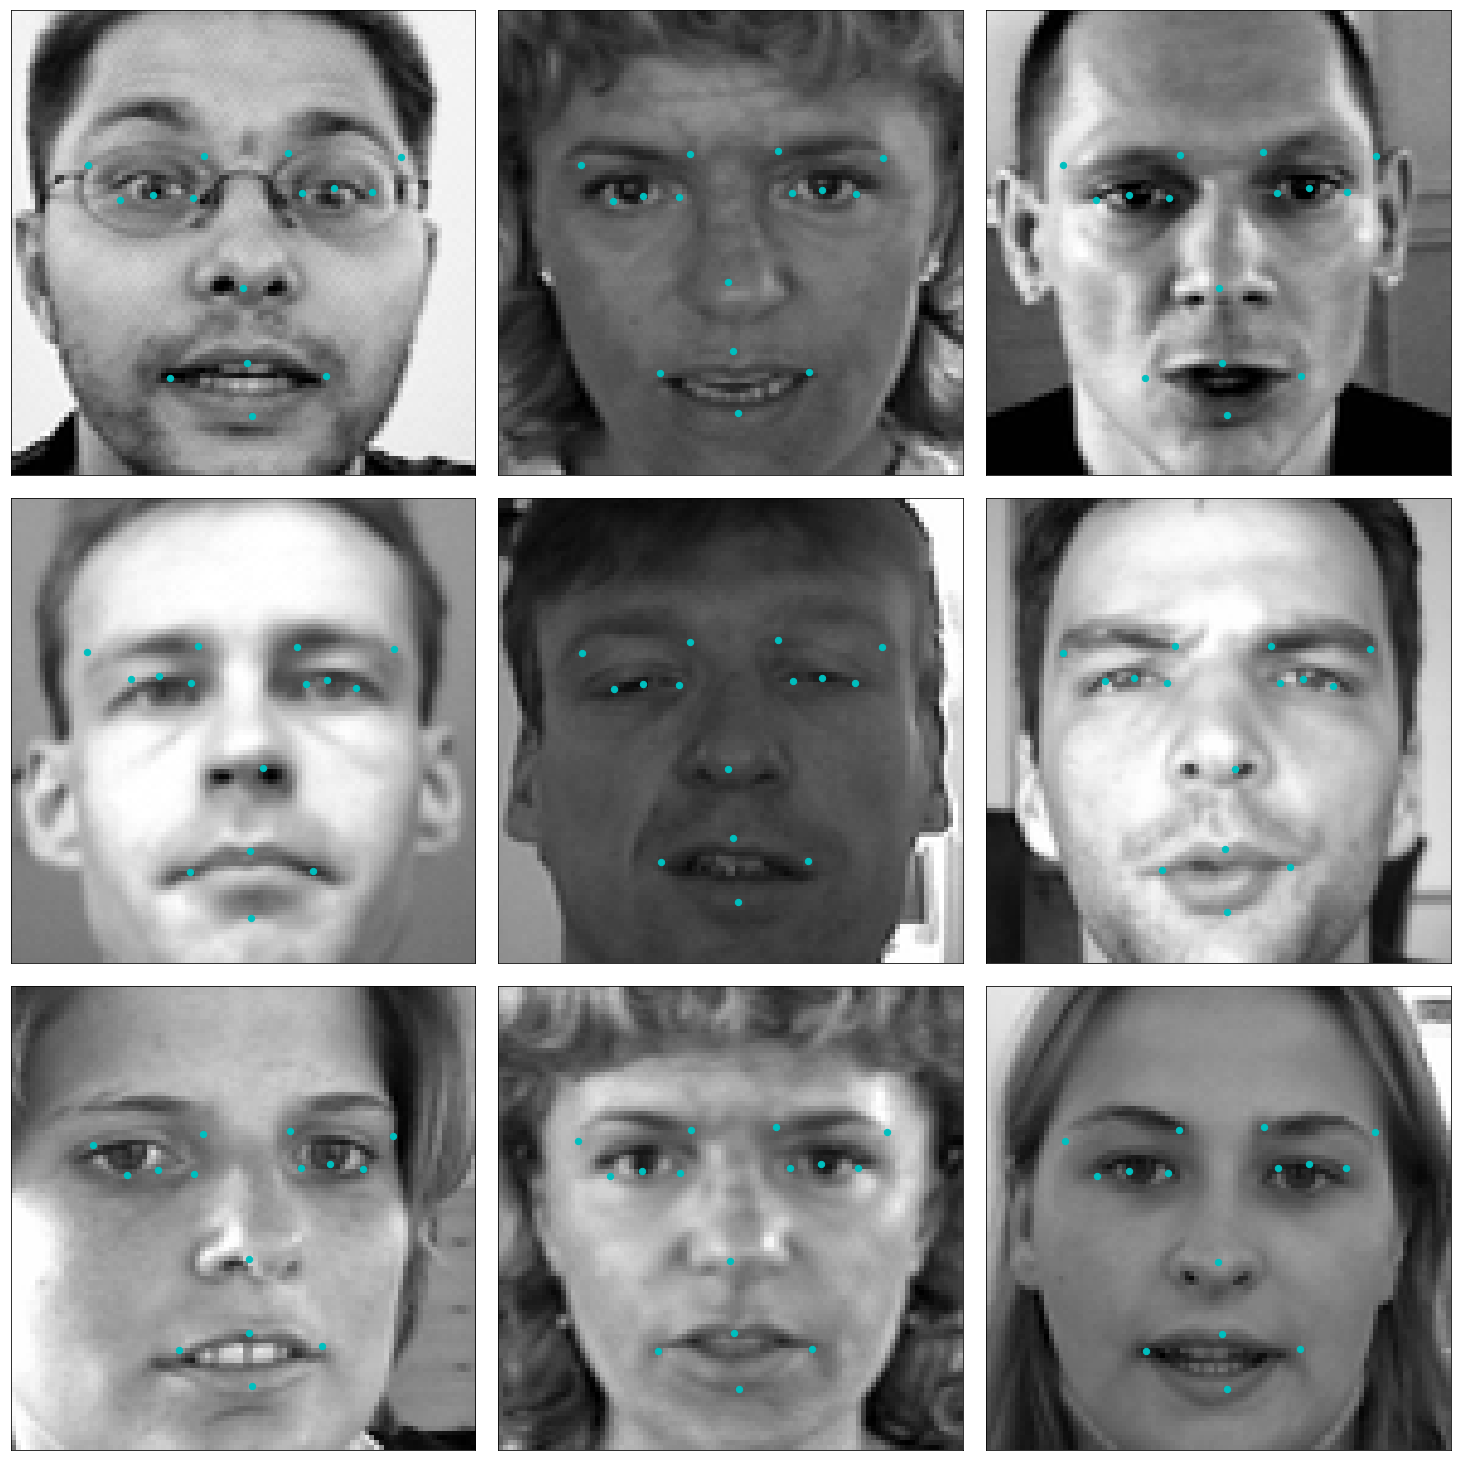

In [45]:
y_test = model.predict(X_test)
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_test[i], y_test[i], ax)